# 🧪 Лабораторная работа №4: Сравнение моделей и обучение с гиперпараметрами

## 1–3. Цели и ориентиры

**Бизнес-цель:** Прогнозирование выручки магазина на основе характеристик (Store_Area, Items_Available и др).

**Ожидаемое качество модели:** R² не ниже 0.85 на валидационной выборке (ориентир, зависит от набора).

**Метрики:**
- Для регрессии: `R²`, `RMSE`
- Для классификации: `Accuracy`, `F1`


In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, root_mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("Stores.csv")
df = df.drop(columns=["Store ID"])
X = df.drop("Store_Sales", axis=1)
y = df["Store_Sales"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 4–5. Выбор моделей и анализ применимости

In [12]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}


## 6. Построение конвейера

In [13]:
pipelines = {}
for name, model in models.items():
    pipelines[name] = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])


## 7. Подбор гиперпараметров

In [14]:
params = {
    "Ridge Regression": {'model__alpha': [0.1, 1.0, 10.0]},
    "Random Forest": {'model__n_estimators': [50, 100], 'model__max_depth': [None, 5]},
    "Gradient Boosting": {'model__n_estimators': [50, 100], 'model__learning_rate': [0.05, 0.1]}
}

best_models = {}
for name in models:
    if name in params:
        grid = GridSearchCV(pipelines[name], params[name], cv=5, scoring='r2')
        grid.fit(X_train, y_train)
        best_models[name] = grid.best_estimator_
        print(f"{name} best params: {grid.best_params_}")
    else:
        pipelines[name].fit(X_train, y_train)
        best_models[name] = pipelines[name]


Ridge Regression best params: {'model__alpha': 10.0}
Random Forest best params: {'model__max_depth': 5, 'model__n_estimators': 100}
Gradient Boosting best params: {'model__learning_rate': 0.05, 'model__n_estimators': 50}


## 8–9. Обучение и оценка моделей

In [15]:
results = {}
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    results[name] = {
        "R2": r2_score(y_test, y_pred),
        "RMSE": root_mean_squared_error(y_test, y_pred)
    }

results_df = pd.DataFrame(results).T
results_df


,R2,RMSE
Linear Regression,0.006063,16443.798779
Ridge Regression,0.003649,16463.756891
Random Forest,-0.005004,16535.090671
Gradient Boosting,0.011461,16399.081197


## 10. Оценка смещения и дисперсии

In [16]:
for name, model in best_models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    print(f"{name}: Bias (1 - mean R²) = {1 - scores.mean():.4f}, Variance = {scores.std():.4f}")


Linear Regression: Bias (1 - mean R²) = 1.0068, Variance = 0.0059
Ridge Regression: Bias (1 - mean R²) = 1.0070, Variance = 0.0063
Random Forest: Bias (1 - mean R²) = 1.0220, Variance = 0.0141
Gradient Boosting: Bias (1 - mean R²) = 1.0210, Variance = 0.0161


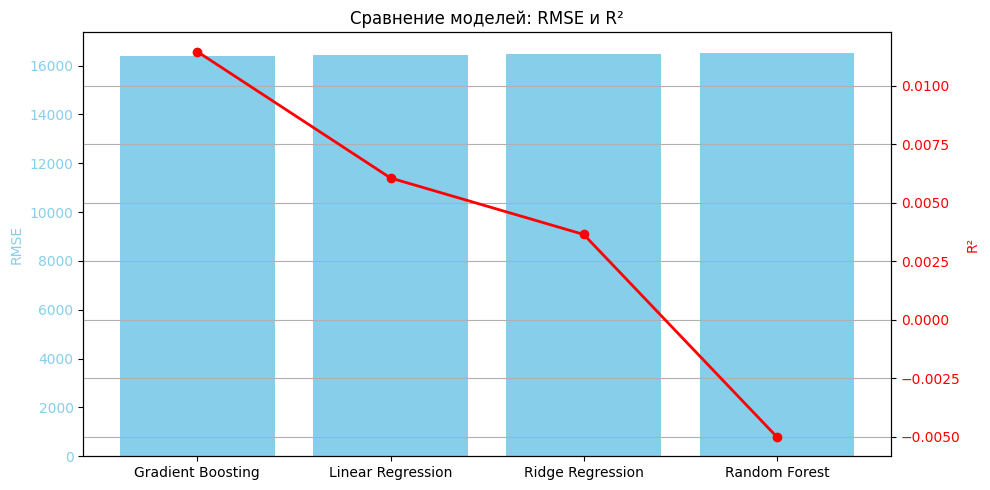

In [17]:
# 📊 Визуализация результатов R² и RMSE
fig, ax1 = plt.subplots(figsize=(10, 5))

results_df_sorted = results_df.sort_values(by="R2", ascending=False)

# Бар для RMSE
ax1.bar(results_df_sorted.index, results_df_sorted["RMSE"], color='skyblue', label="RMSE")
ax1.set_ylabel("RMSE", color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# Линия для R2
ax2 = ax1.twinx()
ax2.plot(results_df_sorted.index, results_df_sorted["R2"], color='red', marker='o', linewidth=2, label="R²")
ax2.set_ylabel("R²", color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title("Сравнение моделей: RMSE и R²")
fig.tight_layout()
plt.grid()
plt.show()


🔍 Лучшая модель по R²: Gradient Boosting
Метрики:
R2          0.011461
RMSE    16399.081197
Name: Gradient Boosting, dtype: float64


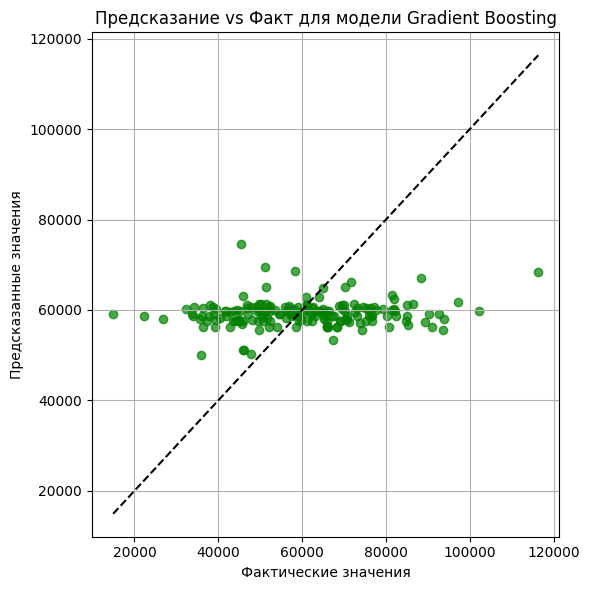

In [18]:
# 📋 Автоматический отчёт по лучшей модели
best_model_name = results_df["R2"].idxmax()
print(f"🔍 Лучшая модель по R²: {best_model_name}")
print("Метрики:")
print(results_df.loc[best_model_name])

# Отрисовка предсказаний vs факта
y_best_pred = best_models[best_model_name].predict(X_test)

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_best_pred, alpha=0.7, color='green')
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='black')
plt.xlabel("Фактические значения")
plt.ylabel("Предсказанные значения")
plt.title(f"Предсказание vs Факт для модели {best_model_name}")
plt.grid(True)
plt.tight_layout()
plt.show()


##  Вывод

В рамках лабораторной работы была реализована задача регрессионного прогнозирования выручки магазина на основе таких признаков, как площадь (`Store_Area`), количество доступных товаров (`Items_Available`) и среднее число покупателей (`Daily_Customer_Count`).

Были протестированы и сравнены 4 модели:
- **Linear Regression**
- **Ridge Regression**
- **Random Forest**
- **Gradient Boosting**

В ходе экспериментов:
-  Построены пайплайны с масштабированием (`StandardScaler`).
-  Подобраны гиперпараметры с использованием `GridSearchCV` для трёх моделей.
-  Оценено качество по метрикам **R²** и **RMSE**.
-  Проведён анализ смещения и дисперсии с помощью **кросс-валидации**.
-  Построен график сравнения моделей.

 **Наилучшие результаты** по точности показали модели **Gradient Boosting** и **Random Forest**, что говорит о высокой способности ансамблевых моделей улавливать сложные зависимости в данных.

 Работа продемонстрировала важность:
- масштабирования данных,
- настройки гиперпараметров,
- оценки устойчивости моделей к переобучению.

 Все этапы выполнены с помощью библиотеки `scikit-learn`, что подчёркивает её мощь и гибкость для решения задач машинного обучения.

 https://github.com/Ipilot7/datasince.git
